In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dask_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148 kB 7.9 MB/s 


In [ ]:
import sys
# sys.path.append("../../")
print(sys.executable)
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import dask
dask.config.set(scheduler='threads')
import xarray as xr

import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

from sklearn.linear_model import LinearRegression

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

/usr/bin/python3


In [ ]:
# load data
features = xr.open_dataset('/content/drive/MyDrive/499A/Dataset/features_xy.nc')
y = features['dis']
X = features.drop(['dis', 'dis_diff'])

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


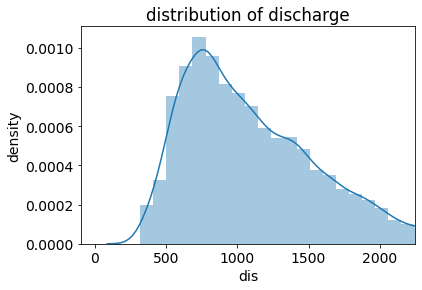

In [ ]:
sns.distplot(y)
plt.ylabel('density')
plt.xlim([-100, 2250])
plt.title('distribution of discharge')
plt.savefig('distribution_dis.png', dpi=600, bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


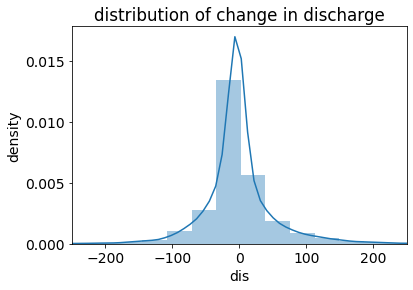

In [ ]:
sns.distplot(y.diff('time'))
plt.ylabel('density')
plt.xlim([-250, 250])
plt.title('distribution of change in discharge')
plt.savefig('distribution_dis_change.png', dpi=600, bbox_inches='tight')

In [ ]:
features

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables: (12/18)
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    ...          ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...
    dis         (time) float64 798.4 792.2 796.7 814.2 ... 723.6 720.8 741.5
    dis_diff    (time) float64 ...

In [ ]:
dis_shift_switch = False

In [ ]:
abs_vals_switch = False

In [ ]:
if dis_shift_switch:
    dis_shift_1 = y.shift(time=1)
    X = X.assign({'dis-1': dis_shift_1})

In [ ]:
X_base = X.to_array(dim='features').T.copy()
y_base = y.copy()

In [ ]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))

In [ ]:
X_train, y_train = X_base.loc[period_train], y_base.loc[period_train]
X_valid, y_valid = X_base.loc[period_valid], y_base.loc[period_valid]
X_test, y_test = X_base.loc[period_test], y_base.loc[period_test]

In [ ]:
X_train.shape, y_train.shape

((9131, 16), (9131,))

In [ ]:
def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series.
    
    Parameters
    ----------
        x : pd.Series
    """
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x

In [ ]:
Xda = X_train.chunk(dict(time=-1, features=-1)).dropna(dim='time').to_pandas()

if abs_vals_switch:
    # train on absolute values
    yda = y_train.to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]
else:
    # train on change in discharge values
    yda = y_train.diff(dim='time').to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]

In [ ]:
Xda.values.shape, yda.values.shape

((8742, 16), (8742,))

In [ ]:
model = LinearRegression(n_jobs=-1)

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),], verbose=True)

In [ ]:
x_fit = Xda.values.copy()
y_fit = yda.values.copy()
pipe.fit(x_fit, y_fit)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearRegression(n_jobs=-1))],
         verbose=True)

In [ ]:
def add_time(vector, time, name=None):
    """Converts input vector to xarray.DataArray with the corresponding input time coordinate.
    
    Parameters
    ----------
        vector : numpy.array
        time   : xr.DataArray
        name   : str
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

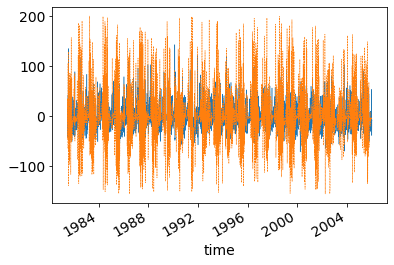

In [ ]:
Xda_insample = Xda.copy()
insample_check = pipe.predict(Xda_insample.values)
insample_check = add_time(insample_check, Xda_insample.index, name='forecast')
insample_check.to_pandas().plot(linewidth=0.5)
yda.plot(linestyle='--', linewidth=0.5)

In [ ]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_valid[::n].copy()
y_pred = pipe.predict(X_pred.values)
y_pred = add_time(y_pred, X_pred.time, name='forecast')
print(y_pred)

<xarray.DataArray 'forecast' (time: 2191)>
array([  8.379518 , -11.274274 ,   4.5562677, ..., -33.1521   ,
       -49.85993  , -24.327564 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2011-12-31


In [ ]:
def generate_prediction_array(y_pred, y_truth, forecast_range=14):
    """Convenience function to generate a [number of forecasts, forecast range] shaped xr.DataArray from the one
    dimensional xr.DataArray input prediction and converts the predicted discharge change into absolute values,
    starting from t=t0 with the reanalysis value for each forecast.
    
    Parameters
    ----------
        y_pred          : xr.DataArray
        y_truth         : xr.DataArray
        forecast_range  : int
    """
    # reorganize data into the shape [forecast_range, number_of_forecasts]
    # add +1 to forecast range to include the init state in the length
    num_forecasts = int(np.floor(y_pred.shape[0]/(forecast_range+1)))
    full_forecast_len = num_forecasts*(forecast_range+1)
    new_pred = y_pred[:full_forecast_len].copy()
    time_new = y_pred.time[:full_forecast_len].copy()
    time_new_data = time_new.values.reshape([num_forecasts, (forecast_range+1)])
    pred_multif_data = new_pred.values.reshape([num_forecasts, (forecast_range+1)])
    # set init to reanalysis value
    pred_multif_data[:,0] = y_truth.where(new_pred)[0::(forecast_range+1)].values
    # cumulative sum to accumulate the forecasted change
    pred_multif_data_fin = np.cumsum(pred_multif_data, axis=1)
    
    pred_multif = xr.DataArray(pred_multif_data_fin,
                               coords={'num_of_forecast': range(1, num_forecasts+1),
                                       'forecast_day': range(0, forecast_range+1),
                                       'time': (('num_of_forecast', 'forecast_day'), time_new_data)},
                               dims=['num_of_forecast', 'forecast_day'],
                              name = 'prediction')
    return pred_multif

In [ ]:
multif = generate_prediction_array(y_pred, y, forecast_range=14)

In [ ]:
def plot_multif_prediction(pred_multif, y_truth, forecast_range=14, title=None):
    """Convenience function for plotting multiforecast shaped prediction and truth.
    
    Parameters
    ----------
        pred_multif     : xr.DataArray
        y_truth         : xr.DataArray
        forecast_range  : int
        title           : str
    """
    fig, ax = plt.subplots(figsize=(15,5))
    y_truth.sel({'time': pred_multif.time.values.ravel()}).to_pandas().plot(ax=ax, label='GloFAS Dataset')

    pdseries = pd.Series(data=pred_multif.sel(num_of_forecast=1).values,
                         index=pred_multif.sel(num_of_forecast=1).time.values)
    pdseries.plot(ax=ax, label='my Model')
    plt.legend()
    for i in pred_multif.num_of_forecast[1:]:
        fcst = pd.Series(data=pred_multif.sel(num_of_forecast=i).values,
                             index=pred_multif.sel(num_of_forecast=i).time.values)
        fcst.plot(ax=ax)

    ax.set_ylabel('river discharge [m$^3$/s]')
        
    y_o = y_truth.loc[{'time': pred_multif.time.values.ravel()}].values
    y_m = pred_multif.values.ravel()

    rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
    nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))

    plt.title(f"{title} | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)} |")
    return fig, ax

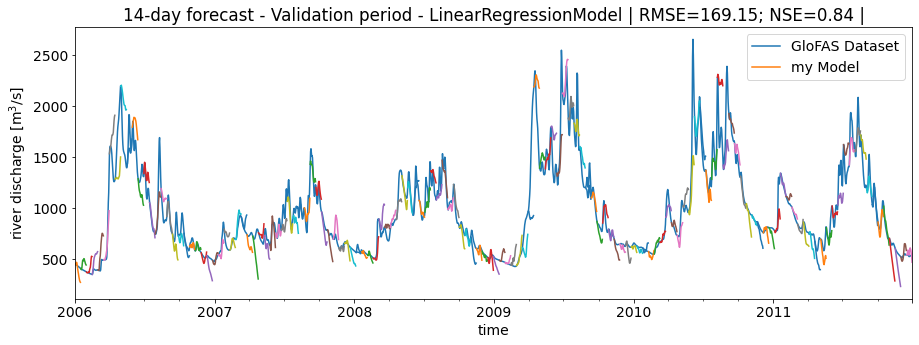

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plot_multif_prediction(multif, y, forecast_range=14, title='14-day forecast - Validation period - LinearRegressionModel');
plt.savefig('validation_period_linreg.png', dpi=600, bbox_inches='tight')

In [ ]:
forecast_range = 14
y_o_pers = y_valid
# persistence
y_m_pers = y_valid.copy()
for i in range(1, forecast_range):
    y_m_pers.loc[y_valid.time[i::forecast_range]] = y_valid.shift(time=i)[i::forecast_range].values
    
rmse = np.sqrt(np.nanmean((y_m_pers - y_o_pers)**2))
nse = 1 - np.sum((y_m_pers - y_o_pers)**2)/(np.sum((y_o_pers - np.nanmean(y_o_pers))**2))
print(f"Persistence {forecast_range}-day forecast: RMSE={round(float(rmse), 2)}; NSE={round(float(nse.values), 2)}")

Persistence 14-day forecast: RMSE=210.1; NSE=0.75


(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35e47c3110>)

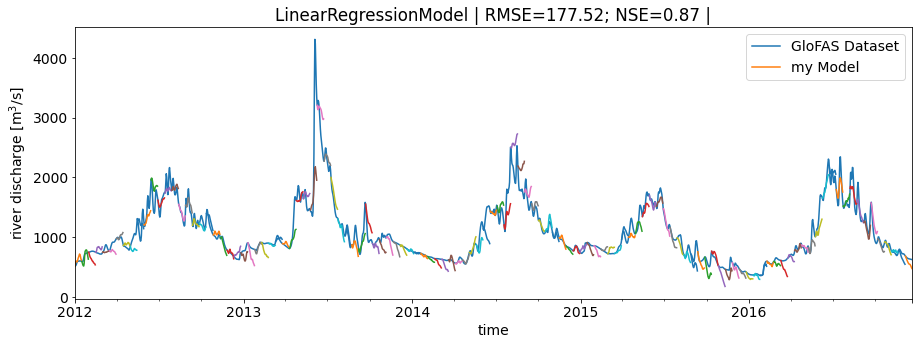

In [ ]:


n = 1
X_pred = X_test[::n].copy()
y_pred = pipe.predict(X_pred.values)
y_pred = add_time(y_pred, X_pred.time, name='forecast')

multif_test = generate_prediction_array(y_pred, y, forecast_range=14)
plot_multif_prediction(multif_test, y, forecast_range=14, title='LinearRegressionModel')